# PILOT STUDY

In [1]:
n = 100 #sample size
data_file = "pilot_"

## Instantiating all 4 Operators

In [ ]:
library(ExpDE) 

# shared parameters
selpars <- list(name = "selection_standard")
stopcrit <- list(names = "stop_maxeval", maxevals = 60000, maxiter = 1000)
probpars <- list(name = "sphere", xmin = -seq(1,20), xmax = 20 + 5 * seq(5, 24))

## Operator 1 -- Arithmetic recombination
recpars1 <- list(name = "recombination_arith")
mutpars1 <- list(name = "mutation_rand", f = 4)
popsize1 <- 300
## Operator 2 -- Binomial recombination
recpars2 <- list(name = "recombination_bin", cr = 0.7)
mutpars2 <- list(name = "mutation_best", f = 3)
popsize2 <- 300
## Operator 3 -- BLX-alpha recombination
recpars3 <- list(name = "recombination_blxAlphaBeta", alpha = 0.4, beta = 0.4)
mutpars3 <- list(name = "mutation_rand", f = 4)
popsize3 <- 230
## Operator 4 -- Eigenvector-based binomial recombination
recpars4 <- list(name = "recombination_eigen", othername = "recombination_bin", cr = 0.9)
mutpars4 <- list(name = "mutation_best", f = 2.8)
popsize4 <- 85

# aggregating
recpars_list <- list(recpars1, recpars2, recpars3, recpars4)
mutpars_list <- list(mutpars1, mutpars2, mutpars3, mutpars4)
popsize_list <- c(popsize1, popsize2 ,popsize3 ,popsize4)

## Gathering and saving the data

In [ ]:
reps = 1:n

for(i in 1:4){
    popsize <- popsize_list[[i]]
    mutpars <- mutpars_list[[i]]
    recpars <- recpars_list[[i]]
    results <- data.frame()
    
    for (j in reps){
        out <- ExpDE(popsize, mutpars, recpars, selpars, stopcrit, probpars)
        results <- rbind(results, out$Fbest)
    }
    
    file_name = paste(data_file, i, ".txt", sep="")
    write.table(results, file=file_name, row.names = FALSE, col.names = FALSE, sep=",")
}

## Read data

In [2]:
results <- data.frame()
for(i in 1:4){
    file_name = paste(data_file, i, ".txt", sep="")
    results <- rbind(results, read.table(file_name, header = 0, row.names = NULL)$V1)
}
results <- t(results)
rownames(results) <- 1:n
colnames(results) <- 1:4

## Checking mean, median, and variance

In [17]:
tmp <- as.matrix(cbind(
                    sapply(1:4, FUN = function(x) mean(results[,x])), 
                    sapply(1:4, FUN = function(x) median(results[,x])), 
                    sapply(1:4, FUN = function(x) var(results[,x]))))
                           
colnames(tmp) <- c("mean", "median", "variance")
rownames(tmp) <- c("Arithmetic", "Binomial", "BLX-alpha", "Eigen-BB")                           
tmp
               

,mean,median,variance
Arithmetic,19.19142,19.15932,7.184901
Binomial,38.89280,39.30336,14.081043
BLX-alpha,42.84416,42.66311,12.206834
Eigen-BB,21.72509,21.49958,34.548583


## Visualizing it

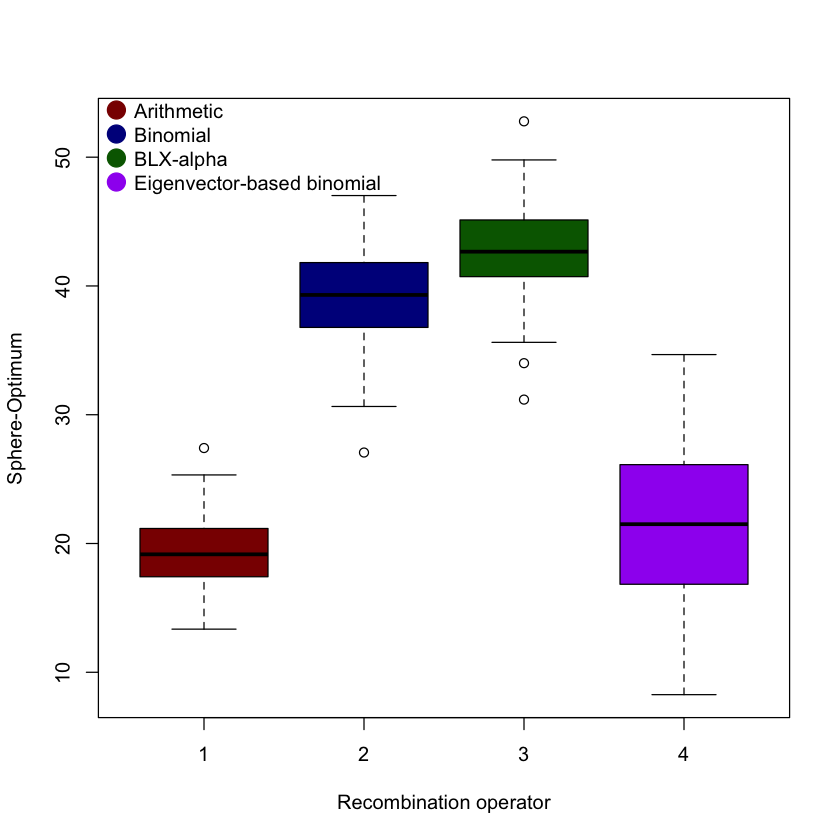

In [18]:
boxplot(results, ylab = "Sphere-Optimum", xlab="Recombination operator", col=c("darkred","darkblue","darkgreen", "purple"))
 legend("topleft", legend = c("Arithmetic","Binomial", "BLX-alpha", "Eigenvector-based binomial") ,col = c("darkred","darkblue","darkgreen", "purple"), 
        bty = "n", pch=20 , pt.cex = 3, cex = 1, horiz = FALSE, inset = c(0.00, -0.02))

# ANOVA assumptions

## 1) Normality of residuals

Loading required package: carData


             Df Sum Sq Mean Sq F value Pr(>F)    
ind           3  42759   14253   838.2 <2e-16 ***
Residuals   396   6734      17                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


	Shapiro-Wilk normality test

data:  my.model$residuals
W = 0.99433, p-value = 0.145


[1] 382 356

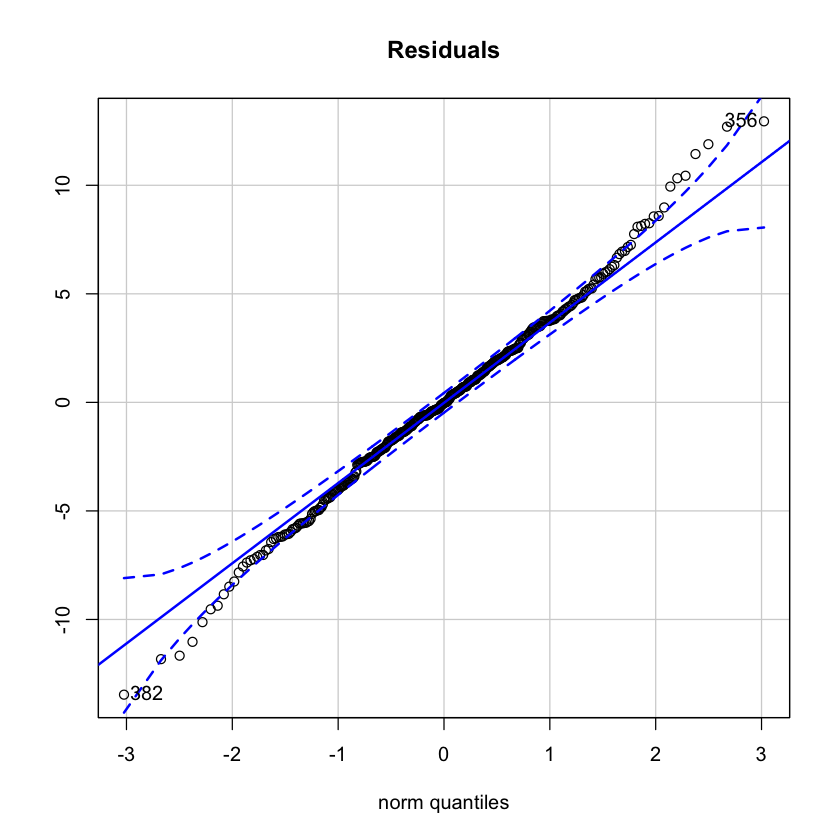

In [19]:
library("car")
res <- data.frame(results)

my.model <- aov(values ~ ind, data=stack(res))
summary.aov(my.model)

shapiro.test(my.model$residuals)
qqPlot(my.model$residuals, main="Residuals", ylab="")

## 2) Homoscedasticity


	Fligner-Killeen test of homogeneity of variances

data:  values by ind
Fligner-Killeen:med chi-squared = 61.394, df = 3, p-value = 2.961e-13


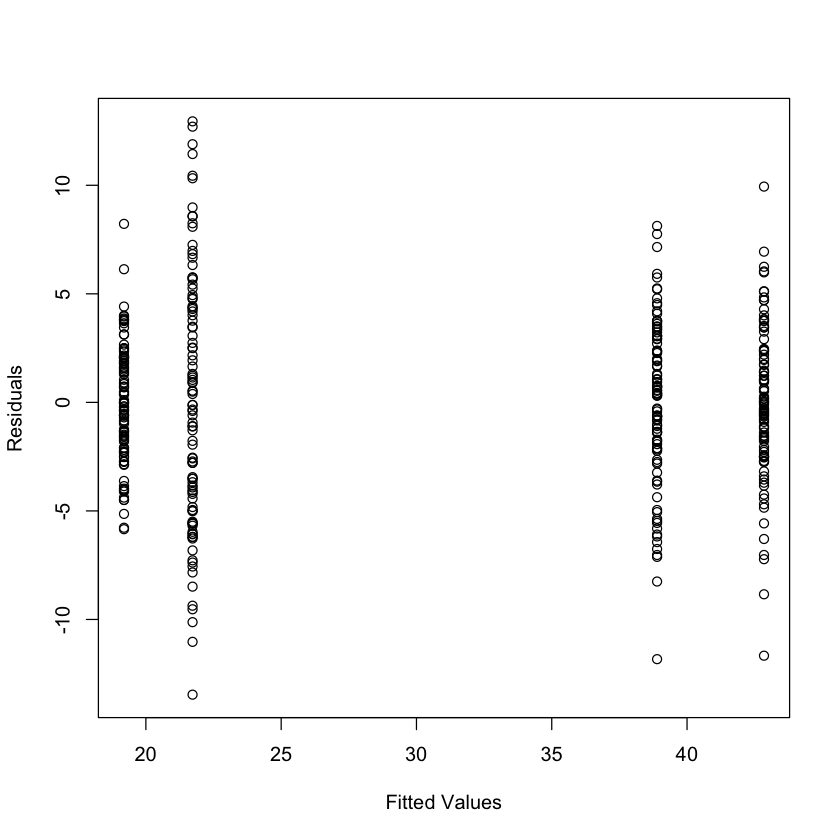

In [25]:
fligner.test(values ~ ind, stack(res))
plot(x=my.model$fitted.values, y=my.model$residuals, xlab = "Fitted Values", ylab="Residuals")

## Type 1 Error Correction: Bonferroni and Sidak

In [26]:
c("method", "significance level", "confidence interval")

sig.adj1 <- 0.05/6
conf.adj1 <- (1-sig.adj1)^6
c("Bonferroni", sig.adj1, conf.adj1)

sig.adj2 = 1 - (1 - 0.05)^(1/6)
conf.adj2 <- (1-sig.adj2)^6
c("Sidak", sig.adj2, conf.adj2)

[1] "method"              "significance level"  "confidence interval"

[1] "Bonferroni"          "0.00833333333333333" "0.951030164689764"

[1] "Sidak"              "0.0085124446108471" "0.95"

## Sample size: ANOVA

In [31]:
b.var <- var(sapply(1:4, FUN = function(x) mean(results[,x])))
w.var <- mean(sapply(1:4, FUN = function(x) var(results[,x])))


power.anova.test(groups = 4, n = NULL,
                 between.var = b.var, within.var = w.var,
                 sig.level = sig.adj1, power = 0.99)


     Balanced one-way analysis of variance power calculation 

         groups = 4
              n = 2.92868
    between.var = 142.5312
     within.var = 17.00534
      sig.level = 0.008333333
          power = 0.99

NOTE: n is number in each group


## Sample Size: T-Test

In [32]:
sig.adj <- sig.adj1

power.t.test(power = 0.85, delta = 0.25, sd = sd(res$X1 - res$X2), sig.level = sig.adj, type = "one.sample")$n
power.t.test(power = 0.85, delta = 0.25, sd = sd(res$X1 - res$X3), sig.level = sig.adj, type = "one.sample")$n
power.t.test(power = 0.85, delta = 0.25, sd = sd(res$X1 - res$X4), sig.level = sig.adj, type = "one.sample")$n

power.t.test(power = 0.85, delta = 0.25, sd = sd(res$X2 - res$X3), sig.level = sig.adj, type = "one.sample")$n
power.t.test(power = 0.85, delta = 0.25, sd = sd(res$X2 - res$X4), sig.level = sig.adj, type = "one.sample")$n

power.t.test(power = 0.85, delta = 0.25, sd = sd(res$X3 - res$X4), sig.level = sig.adj, type = "one.sample")$n

[1] 5178.606

[1] 4013.247

[1] 8513.329

[1] 5629.246

[1] 12197.43

[1] 10446.57

In [36]:
## Required sample size is too big! Checking the power (to minimize type 2 error)

In [ ]:
power.t.test(n = 7000, delta = 0.25, sd = sd(res$X1 - res$X2), sig.level = sig.adj, type = "one.sample")$power
power.t.test(n = 7000, delta = 0.25, sd = sd(res$X1 - res$X3), sig.level = sig.adj, type = "one.sample")$power
power.t.test(n = 7000, delta = 0.25, sd = sd(res$X1 - res$X4), sig.level = sig.adj, type = "one.sample")$power

power.t.test(n = 7000, delta = 0.25, sd = sd(res$X2 - res$X3), sig.level = sig.adj, type = "one.sample")$power
power.t.test(n = 7000, delta = 0.25, sd = sd(res$X2 - res$X4), sig.level = sig.adj, type = "one.sample")$power

power.t.test(n = 7000, delta = 0.25, sd = sd(res$X3 - res$X4), sig.level = sig.adj, type = "one.sample")$power